<a href="https://colab.research.google.com/github/abernauer/Deep-Learning-with-Python/blob/master/Chapter5Deeplearningforcomputervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 5: Deep learning for computer vision

#5.1 Introduction to convnets

We're about to dive into the theory of what convnets are and why they have been so successful at computer vision tasks. First will revisit the MNIST digit example

In [ ]:
from keras import layers 
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


A convnet takes as input tensors of shape( image_height, image_width, image_channels) (not including the batch dimension). In this case, we'll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We did this by passing the argument input_shape=(28, 28, 1) to the first layer.

Let's look at the architecture so far:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (32 or 64).

The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely connected classifier network like those you're already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

In [ ]:
model.add(layers.Flatten())       
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We'll do 10-way classification, using a final layer with 10 outputs and a sofmax activitaion.





In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

The (3, 3, 64) outputs are flattened into vectors of shape (576, ) before going through two Dense layers. 

Let's train the convnet on the MNIST digits.


In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels),  (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
60000/60000 [==============================] - 49s 816us/step - loss: 0.1768 - accuracy: 0.9441
Epoch 2/5
60000/60000 [==============================] - 49s 813us/step - loss: 0.0459 - accuracy: 0.9856
Epoch 3/5
60000/60000 [==============================] - 48s 799us/step - loss: 0.0320 - accuracy: 0.9901
Epoch 4/5
60000/60000 [==============================] - 48s 793us/step - loss: 0.0239 - accuracy: 0.9921
Epoch 5/5
60000/60000 [==============================] - 47s 791us/step - loss: 0.0181 - accuracy: 0.9945


Let's evaluate the model on the test data:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 3s 286us/step


In [ ]:
test_acc

0.9916999936103821

The basic convnet has a test accuracy of 99.2% which reduced the error rate in comparison the densely connected network from chapter 2.

#5.1.1 The convolution operation

The fundamental difference between a densely connected layer and a convolution layer is this: Dense layers learn global pattern in their input feature space, whereas convolution layers learn local patterns: in the case of images, patterns found in small 2D windows of the inputs. In the previous example, these windows were all 3 x 3. 

This key characteristic gives convnets two interesting properties:

* *The patterns they learn are translation invariant*. After learning a certain pattern in the lower-rigth corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn pattern annew if it appeared at a new location. This makes convnets data efficient when processing images (because *the visual world is fundamentally translation invariant*): they need fewer training samples to learn representations that have generalization power.

* *They can learn spatial hierarchies of patterns*. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because *the visual world is fundamentally spatially hierarchical*.)

Convolutions operate over 3D tensors, called *feature maps*, with two spatial axes( *height* and *width*) as well as a *depth* axis (also called the *channels* axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an *output feature map*. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for *filters*. Filters encode specific apsects of the input: at a high level, a single filter could encode the concept "presence of a face in the input," for instance.

In the MNIST example, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a 26 X 26 grid of values, which is a *response map* of the filter over the input, indicating the response of that filter pattern at different locations in the input. That is what the term *feature map* means: every dimension in the depth axis is a feature (or filter), and the 2D tensor output[:, :, n] is the 2D spatial *map* of the response of this filter over the input.

Convolutions are defined by two key parameters:

* *Size of the patches extracted from the inputs* -- These are typically 3 x 3 or 5 x 5. In the example, they were 3 x 3, which is a common choice.
* *Depth of the output feature map* -- The number of filters computed by the convolution. The example started it out with a depth of 32 and ended with a depth of 64.

In Keras Conv2D layers, these parameters are the first arguments passed to the layer: Conv2D(output_depth, (window_height, window_width)).

A convolution works by *sliding* these windows of size 3 x 3 or 5 x 5 over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features. Each such 3D patch is then transformed (via a tensor product with the same learned weigth matrix, called the *convolution kernel*) into a 1D vector of shape (output_depth,). All of these vectors are then spatially reassembled into a 3D output map of shape (height, width, output_depth). Every spatial location in the output feature map corresponds to the same location in the input feature map. For instance, with 3 x 3 windows, the vector output[i, j, :] comes from the 3D patch input[i-1:i+1, j-1:j+1, :]. 

Note that the output width and height may differ from the input width and height. They may differ for two reasons:
* Border effects, which can be countered by padding the input feature map
* The use of *strides*, which I'll define in a second.

# UNDERSTANDING BORDER EFFECTS AND PADDING 

Consider a 5 x 5 feature map (25 tiles total). There are only 9 tiles around which you can center a 3 x 3 window, forming a 3 x 3 grid. Hence, the output feature map will be 3 x 3. It shrinks a little; by exactly two tiles alongside each dimension, in this case. You can see this border effect in action in the earlier example: you start with 28 x 28, which shrinks to 26 x 26 after the first convolution layer.

If you want to get an output feature map with the same spatial dimensions as the input, you can use *padding*. Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. For a 3 x 3 window, you add one column on the right, one column on the left, on row at the top, and one row at the bottom. For a 5 x 5 window, you add two rows.

In Conv2D layers, padding is configurable via the padding argument, whic takes two values: "valid", which means no padding (only valid window locations will be used); and "same", which means "pad in such a way as to have an output with the same width and height as the input." The padding argument defaults to "valid".

#UNDERSTANDING CONVOLUTION STRIDES

The other factor that can influenc output size is the notion of *strides*. The description of convolutio so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance, between two succesive windows is a parameter fo the convolution, called its *stride*, which defaults to 1. It's possible to have *strided convolutions*: convolutions with a stride higher than 1. 

Using stride 2 means the witdh and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). Strided convolutions are rarely used in practice, although they can come in handy for some types of models; it's good to be familiar with the concept.

To downsample feature maps, instead of strides, we tend to use the *max-pooling* operation, which you saw in action in the first convnet example. Let's look at it in more depth.

#The max-pooling operation

In the convnet example, you may have noticed that size of the feature maps is halved after every MaxPooling2D layer. For instance, before the first MaxPooling2D layers, the feature map is 26 x 26, but the max-pooling operation halves it to 13 x 13. That's the role of max pooling: to aggressively downsample feature maps, much like strided convolutions. 

Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It's conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation(the convolution kernel), they're transformed via a hardcoded max tensor operation. A big difference from convolution is that max pooling is usually done with 2 x 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. On the other hand, convolution is typically done with 3 x 3 windows and no stride (stride 1).

Why downsample feature maps this way?  Why not remove the max-pooling layers and keep fairly large feature maps all the way up? Let's look at this option. The convolutional base of the model would then look like this:

In [ ]:
from keras import models
from keras import layers

model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

Here's a summary of the model:

In [ ]:
model_no_max_pool.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


What's wrong with this setup? Two things:

* It isn't conducive to learning a spatial hierarchy of features. The 3 x 3 windows in the third layer will only contain information coming from 7 x 7 windows in the initial input. The high-level pattern learned by the convnet will still be very small with regard to the intial input, which may not be enough to learn to classify digits. We need the features from the last convolution layer to contain information about the totality of the input.

* The final feature map has 22 x 22 x 64 = 30,976 total coefficients per sample. This is huge. If you were to flatten it to stick a Dense layer of size 512 on top, that layer would have 15.8 million parameters. This is far too large for such a small model and would result in intense overfitting.

In short, the reason to use downnsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover). 

Note that max pooling isn't the only way you can acheive such downsampling. As you already know, you can also use strides in the prior convolution layer. And you can use average pooling instead of max pooling, where each local input patch is transformed by taking the average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. But max pooling tends to work better than these alternative solutions. In a nutshell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map, and it's more informative to look at the *maximal presence* of different features than at their *average presence*. So the most reasonable subsampling strategy is to first produce dense maps of features and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs or averaging input patches, which could cause you to miss or dilute feature-presence information. 

#5.2 Training a convent from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you'll likely ecnounter in practice if you ever do computer vision in a professional context. A "few" samples can mean anywhere from a few hundred to a few tens of thousands of images. As a practical example, we'll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs. We'll use 2,000 pictures for training-- 1,000 for validation, and 1,000 for testing.

In this section, we'll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. You'll start by natively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracry of 71%. At that point, the main issue will be overfitting. Then we'll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, you'll improve the network to reach an accuracy of 82%.

In the next section, we'll review two more essential techniques for applying deep learning to small datasets: *faeture extraction with a pretrained network* (improving accuracy to 96% from 90%) and *fine-tuning a pretrained network* (getting to an accuracy of 97%) These strategies will form the workflow or toolbox for image classification on small datasets.

Listing 5.4 Copying images to training, validation, and test directories

In [5]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  is_google_colab = True
  print("In Google CoLab")
except:
  is_google_colab = False



Mounted at /content/drive
In Google CoLab


In [6]:
!find /content/drive/My\ Drive/Colab\ Notebooks/

/content/drive/My Drive/Colab Notebooks/
/content/drive/My Drive/Colab Notebooks/Copy of Chapter2:building blocks of neural nets.ipynb
/content/drive/My Drive/Colab Notebooks/Chapter2:building blocks of neural nets.ipynb
/content/drive/My Drive/Colab Notebooks/ListComphrensions.ipynb
/content/drive/My Drive/Colab Notebooks/Chapter3_Getting_started_with_neural_networks.ipynb
/content/drive/My Drive/Colab Notebooks/Chapter_4Fundamentalsofmachinelearning.ipynb
/content/drive/My Drive/Colab Notebooks/dogs-vs-cats.zip
/content/drive/My Drive/Colab Notebooks/Chapter5Deeplearningforcomputervision.ipynb
/content/drive/My Drive/Colab Notebooks/Python for Data Scientists & Engineers.ipynb
/content/drive/My Drive/Colab Notebooks/Copy of Python for Data Scientists & Engineers.ipynb
/content/drive/My Drive/Colab Notebooks/sampleSubmission.csv
/content/drive/My Drive/Colab Notebooks/test1.zip
/content/drive/My Drive/Colab Notebooks/train.zip


In [7]:
!ls

cats_and_dogs_small  sample_data	   test1      train
drive		     sampleSubmission.csv  test1.zip  train.zip


In [10]:
!mv train/*.jpg ./drive/My\ Drive/Colab\ Notebooks\

In [11]:
!mv test1/*.jpg ./drive/My\ Drive/Colab\ Notebooks\

In [12]:
import os, shutil
# from earlier find ./drive/My\ Drive/Colab\ Notebooks/dogs-vs-cats.zip
# /content/drive/My Drive/
print(os.getcwd())
# current wd is gdrive

original_dataset_dir = '/content/drive/My Drive/Colab Notebooks'

base_dir = '/content/drive/My Drive/Colab Notebooks/cats_and_dogs_small'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

/content


In [13]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [14]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [15]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total training dog images: 500


In [16]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [17]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [18]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


After refactoring the code for google Colab, We have 2,000 training imgages, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, so we can use classification accuracy as a measure of success.

#5.2.3 Building your network

In [19]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's look at the model summary and how the feature map changes with each layer:

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [22]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#5.2.4 Data preprocessing 

In [26]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [28]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 118s 1s/step - loss: 0.6895 - acc: 0.5385 - val_loss: 0.7088 - val_acc: 0.5390
Epoch 2/30
100/100 [==============================] - 115s 1s/step - loss: 0.6596 - acc: 0.6130 - val_loss: 0.5722 - val_acc: 0.6200
Epoch 3/30
100/100 [==============================] - 116s 1s/step - loss: 0.6130 - acc: 0.6615 - val_loss: 0.6123 - val_acc: 0.6290
Epoch 4/30
100/100 [==============================] - 118s 1s/step - loss: 0.5670 - acc: 0.7065 - val_loss: 0.7807 - val_acc: 0.5970
Epoch 5/30
100/100 [==============================] - 118s 1s/step - loss: 0.5356 - acc: 0.7245 - val_loss: 0.5517 - val_acc: 0.6810
Epoch 6/30
100/100 [==============================] - 118s 1s/step - loss: 0.5075 - acc: 0.7420 - val_loss: 0.5914 - val_acc: 0.6840
Epoch 7/30
100/100 [==============================] - 118s 1s/step - loss: 0.4747 - acc: 0.7680 - val_loss: 0.5648 - val_acc: 0.7180
Epoch 8/30
100/100 [==============================] - 118s 1s/step - 

In [29]:
model.save('cats_and_dogs_small_1.h5')

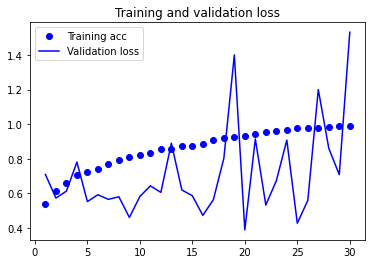

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#5.2.5 Using data augmentation

In [31]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=-0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2, 
      horizontal_flip=True,
      fill_mode='nearest')

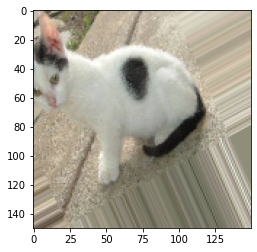

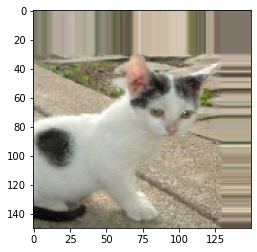

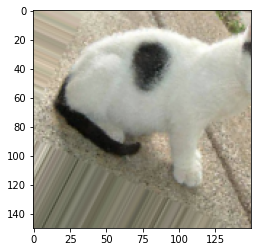

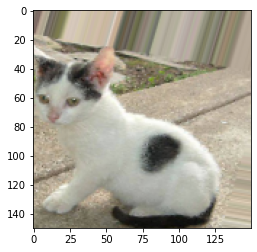

In [34]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for
          fname in os.listdir(train_cats_dir)]

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=32):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()